In [5]:
#### importing some libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment
from scipy.stats import norm
import warnings
import itertools
import matplotlib.colors as mcolors
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [67]:
### functions to compute delta S

def sig_est(mean):
  """
  estimate standard deviation using the mean rating
  for a color-concept pair
  """
  return np.maximum(1.4 * mean * (1-mean), .1)

def compute_semantic_distance(x1, x2, x3, x4):
    """
    get semantic distance between a set of color concept
    association ratings.
    x1, x2, x3, and x4 are the ratings for four colors as
    described in https://schlosslab.discovery.wisc.edu/wp-content/uploads/2021/08/SchlossLeggonLessard2021.pdf


        concept1                concept2
          |\                       /|
          | \                     / |
       x1 |  \ x2             x3 /  | x4
          |   \                 /   |
          |    \               /    |
        color1  color2    color1  color2
    """
    num = (x1 + x4) - (x2 + x3)

    denom = np.sqrt(sig_est(x1)**2 + sig_est(x2)**2 + sig_est(x3)**2 + sig_est(x4)**2)

    p_dx_gt_zero = norm.cdf(num / denom)
    p_dx_lt_zero = 1 - p_dx_gt_zero
    semdist = np.absolute(p_dx_gt_zero - p_dx_lt_zero)

    return semdist



### this function gets all the delta S values for a pair of concepts
def get_all_semdists(concept1, concept2):
    """
    compute semantic distances between all color pairs for a concept
    concept1 & concept2 are color-concept association
    vectors for two concepts
    """
    dists = []
    pairs = []

    for color1 in range(concept1.shape[0]):
        for color2 in range(color1):
            x1, x2 = concept1[color1], concept1[color2]
            x3, x4 = concept2[color1], concept2[color2]
            #semdists[color1][color2] = get_semdist(x1, x2, x3, x4)
            if np.any(np.isnan([x1,x2,x3,x4])):
              continue
            dists.append(compute_semantic_distance(x1, x2, x3, x4))
            pairs.append(tuple([color1,color2]))


    return dists, pairs



def compute_total_variation(vec1, vec2):
  """
  compute total variation distance between two vectors
  """
  return np.sum(np.abs(vec1-vec2))



def assignment_solve( ratings, method="balanced"):
    """
    Input is a m x n array of (concepts) x (colors) filled with association ratings
    Output is a list of length m with the index of the color that should be associated with each concept
    """
    m,n = ratings.shape
    assert m <= n, "More concepts than colors, assignment impossible!"

    # isolated merit function (only considers target in isolation)
    if method == "isolated":
        merit_matrix = ratings

    # balanced merit function (balances ratings of target vs off-target objects with each color)
    elif method == "balanced":
        t = 1  # this is the penalty parameter. t=1 for balanced, t=0 recovers isolated case.
        merit_matrix = np.zeros((m,n))
        for i in range(m):
            for j in range(n):
                merit_matrix[i,j] = ratings[i,j] - t*ratings[np.arange(m)!=i,j].max()



    # baseline merit function (uniformly bad assignment)
    elif method == "baseline":
        merit_matrix = np.zeros((m,n))
        for i in range(m):
            for j in range(n):
                merit_matrix[i,j] = -abs( ratings[i,j] - ratings[np.arange(m)!=i,j].max() )

    else:
        assert False, "unknown method in assignment problem"

    row_ind, col_ind = linear_sum_assignment( merit_matrix, maximize=True )
    return col_ind



def visualize_color_patches(hex_colors, concept_names):
    fig, ax = plt.subplots(1, len(hex_colors), figsize=(len(hex_colors) * 2, 2), facecolor=(143/255, 143/255, 143/255))
    
    if len(hex_colors) == 1:
        ax = [ax]
    
    for i, color in enumerate(hex_colors):
        ax[i].add_patch(patches.Rectangle((0, 0), 1, 1, color=color))
        ax[i].set_xlim(0, 1)
        ax[i].set_ylim(0, 1)
        ax[i].axis('off')
        ax[i].set_title(concept_names[i], fontsize=10)
        ax[i].set_facecolor((143/255, 143/255, 143/255))
    
    plt.show()


def make_ratings_mat(grouped_ratings_df):
    
    mat = np.zeros((len(np.unique(grouped_ratings_df.prompt)),71))
    for i,con in enumerate(np.unique(grouped_ratings_df.prompt)):
        ds = grouped_ratings_df[grouped_ratings_df.prompt==con]
        mat[i,:] = ds.iloc[:,3].values


    mat = pd.DataFrame(mat, index =np.unique(grouped_ratings_df.prompt), columns = np.arange(mat.shape[1]) )
    cmeans = mat.mean().values
    return mat, cmeans




In [68]:
color_dict = pd.read_csv('https://raw.githubusercontent.com/kushinm/cc-assoc-ratings/main/UW71coordinates_long.csv')
p1 = ['corn','carrot','grape','banana']
p2 =['sleeping','driving','peach','cherry']
p3 = ['working','leisure','safety','comfort']
p4 = ['eggplant','celery','efficiency','speed']
p5= ['working','leisure','grape','banana']
p6 = ['eggplant','celery','peach','cherry']
p7 = ['corn','carrot','safety','comfort']
p8 = ['sleeping','driving','efficiency','speed']


p9 = ['corn','carrot','peach','cherry']
p10 = ['sleeping','driving','grape','banana']
p11 = ['working','leisure','efficiency','speed']
p12 = ['eggplant','celery','safety','comfort']
p13 = ['working','leisure','peach','cherry']
p14 = ['eggplant','celery','grape','banana']
p15 = ['corn','carrot','efficiency','speed',]
p16 = ['sleeping','driving','safety','comfort']
plist=[p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16]


In [69]:
### load human ratings and average ratings

set_1_raw = pd.read_csv('../../data/uw71_set1_redo_raw.csv')
set_2_raw = pd.read_csv('../../data/uw71_set2_raw.csv')
set_3_raw = pd.read_csv('../../data/uw71_set3_raw.csv')
set1_grouped = set_1_raw.groupby(['concept','prompt','color_index']).response.agg(mean_rating = 'mean', se ='sem').reset_index()
set2_grouped = set_2_raw.groupby(['concept','prompt','color_index']).response.agg(mean_rating = 'mean', se ='sem').reset_index()
set3_grouped = set_3_raw.groupby(['concept','prompt','color_index']).response.agg(mean_rating = 'mean', se ='sem').reset_index()

ratings1,ratings_cmeans1= make_ratings_mat(set1_grouped)
ratings2,ratings_cmeans2= make_ratings_mat(set2_grouped)
ratings3,ratings_cmeans3= make_ratings_mat(set3_grouped)

concept_list = set1_grouped.pivot(index=['prompt','concept'], columns='color_index', values='mean_rating').reset_index().sort_values(by=['concept','prompt']).reset_index(drop=True)['prompt'].values
concept_list.sort()
concept_order  = {concept: i for i, concept in enumerate(concept_list)}

### vertically stack the ratings matrices
ratings_human = pd.concat([ratings1,ratings2,ratings3])
ratings_human['concept'] = ratings_human.index
ratings_human = ratings_human.reset_index(drop=True)




In [70]:
gpt_assoc_hex_images = pd.read_csv('../../data/all_stim_hex_plus_patch.csv', index_col=0)
gpt_assoc_hex_images = gpt_assoc_hex_images.pivot(index='concept', columns='color_index', values='response').rename_axis(None, axis=1).reset_index()

In [71]:
ratings_human = ratings_human[ratings_human['concept'].isin(set_3_raw.prompt.unique())].reset_index(drop=True)
gpt_assoc_hex_images = gpt_assoc_hex_images[gpt_assoc_hex_images['concept'].isin(set_3_raw.prompt.unique())].reset_index(drop=True)

['corn', 'carrot', 'grape', 'banana']
Optimal color assignment for concept set 1:
['#ffffff', '#cc4f1b', '#600b84', '#c8e97d']


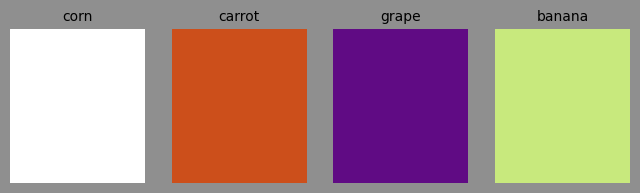


['sleeping', 'driving', 'peach', 'cherry']
Optimal color assignment for concept set 2:
['#512d5f', '#3efe44', '#f1a78a', '#ea1d1d']


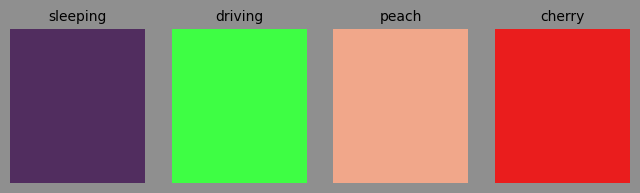


['working', 'leisure', 'safety', 'comfort']
Optimal color assignment for concept set 3:
['#000000', '#8558f4', '#dddddd', '#a06776']


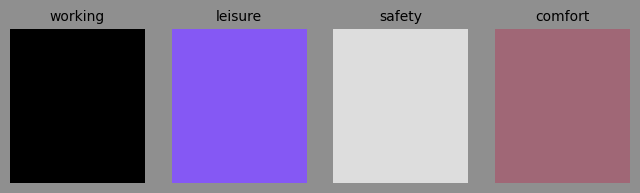


['eggplant', 'celery', 'efficiency', 'speed']
Optimal color assignment for concept set 4:
['#600b84', '#0e8a19', '#5e78a1', '#ea1d1d']


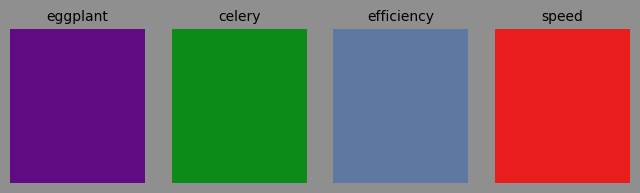


['working', 'leisure', 'grape', 'banana']
Optimal color assignment for concept set 5:
['#3b3b3b', '#a0bae6', '#600b84', '#fcdb42']


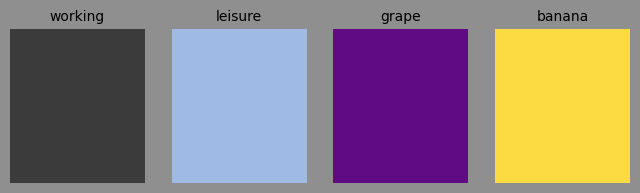


['eggplant', 'celery', 'peach', 'cherry']
Optimal color assignment for concept set 6:
['#600b84', '#73cf10', '#f7a75a', '#ea1d1d']


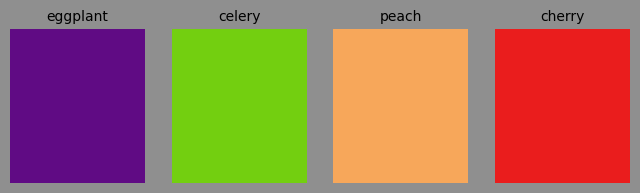


['corn', 'carrot', 'safety', 'comfort']
Optimal color assignment for concept set 7:
['#fcdb42', '#cc4f1b', '#8cf47e', '#a06776']


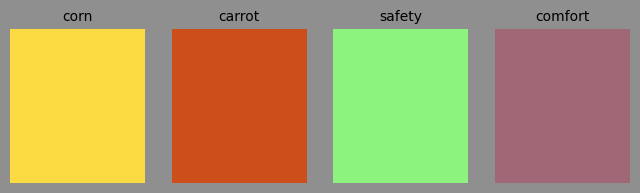


['sleeping', 'driving', 'efficiency', 'speed']
Optimal color assignment for concept set 8:
['#512d5f', '#0e8a19', '#ffffff', '#e81a4b']


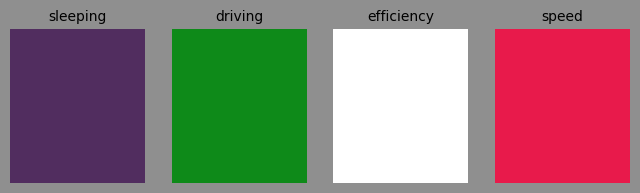


['corn', 'carrot', 'peach', 'cherry']
Optimal color assignment for concept set 9:
['#d5b811', '#ac6619', '#f1a78a', '#ea1d1d']


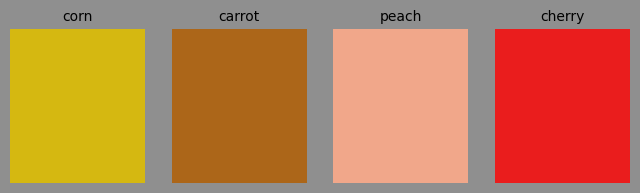


['sleeping', 'driving', 'grape', 'banana']
Optimal color assignment for concept set 10:
['#1c3d61', '#ea1d1d', '#b62ef2', '#d0b85a']


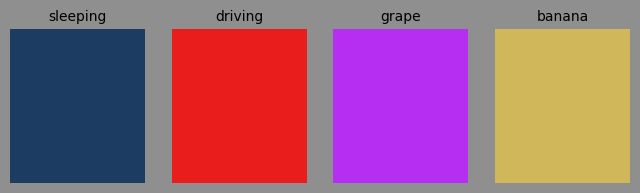


['working', 'leisure', 'efficiency', 'speed']
Optimal color assignment for concept set 11:
['#3b3b3b', '#90689f', '#ffffff', '#ea1d1d']


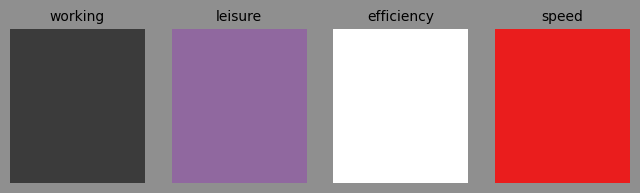


['eggplant', 'celery', 'safety', 'comfort']
Optimal color assignment for concept set 12:
['#600b84', '#0e8a19', '#d0e942', '#a06776']


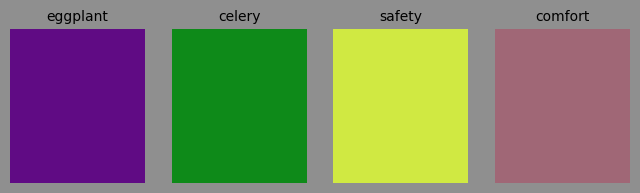


['working', 'leisure', 'peach', 'cherry']
Optimal color assignment for concept set 13:
['#3b3b3b', '#d5a9e4', '#f1a78a', '#ea1d1d']


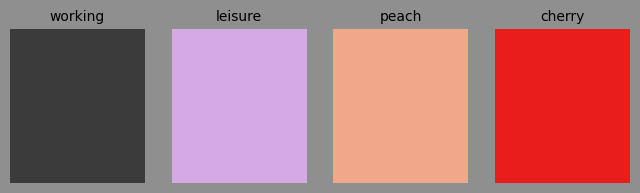


['eggplant', 'celery', 'grape', 'banana']
Optimal color assignment for concept set 14:
['#000000', '#8cf47e', '#c94e4b', '#fcdb42']


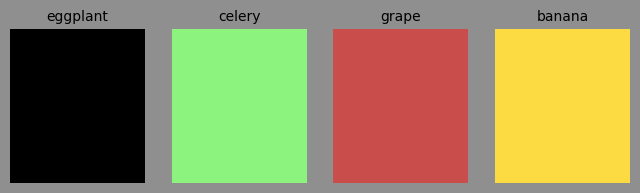


['corn', 'carrot', 'efficiency', 'speed']
Optimal color assignment for concept set 15:
['#fcdb42', '#ac6619', '#5e78a1', '#ea1d1d']


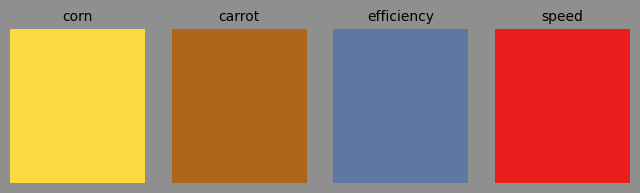


['sleeping', 'driving', 'safety', 'comfort']
Optimal color assignment for concept set 16:
['#512d5f', '#ea1d1d', '#d0e942', '#a06776']


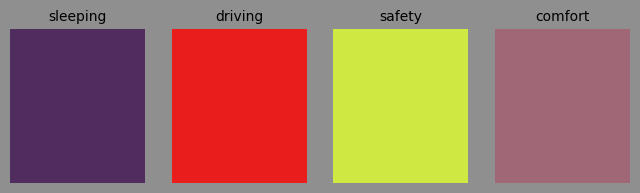

In [76]:
true_assignments = []
for i in range(len(plist)):
    concepts = plist[i]
    print(concepts)
    subset = ratings_human[ratings_human['concept'].isin(concepts)]

     # Sort the subset DataFrame by the 'concept' column following the order in 'concepts'
    subset['concept'] = pd.Categorical(subset['concept'], categories=concepts, ordered=True)
    subset = subset.sort_values('concept')
    
    ratings = subset.drop('concept', axis=1).values
    color_assignment = assignment_solve(ratings, method='balanced')
    selected_colors = color_dict.iloc[color_assignment]['color_hex'].tolist()
    
    print('Optimal color assignment for concept set {}:'.format(i+1))
    print(selected_colors)
    visualize_color_patches(selected_colors, concepts)
    
    print('')
    assignment_dict = {concept: color for concept, color in zip(concepts, selected_colors)}
    true_assignments.append(assignment_dict)

Optimal color assignment for concept set 1:
['#c7b88b', '#cc4f1b', '#600b84', '#d0e942']


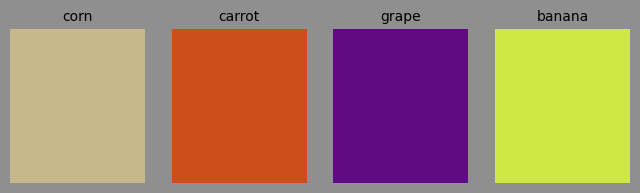


Optimal color assignment for concept set 2:
['#000000', '#d5b811', '#f7a75a', '#e81a4b']


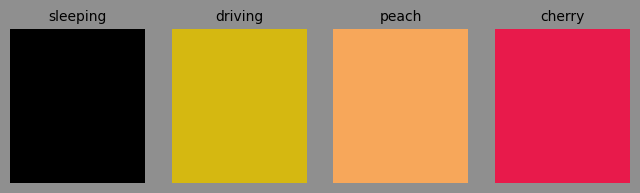


Optimal color assignment for concept set 3:
['#777777', '#cd26c7', '#73cf10', '#632b14']


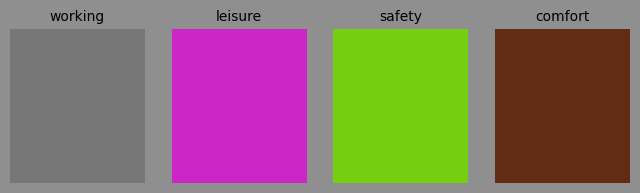


Optimal color assignment for concept set 4:
['#72005e', '#608218', '#b9b9b9', '#ea1d1d']


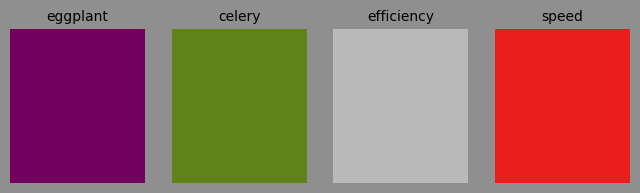


Optimal color assignment for concept set 5:
['#777777', '#4bcf8e', '#512d5f', '#d5b811']


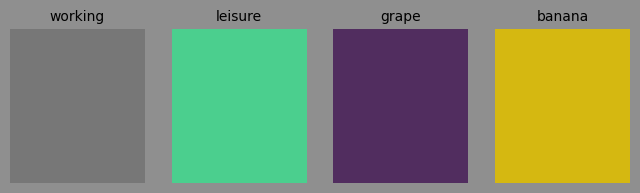


Optimal color assignment for concept set 6:
['#3518ad', '#aac510', '#f7a75a', '#ea1d1d']


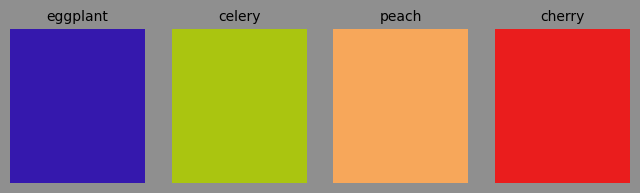


Optimal color assignment for concept set 7:
['#d5b811', '#cc4f1b', '#73cf10', '#632b14']


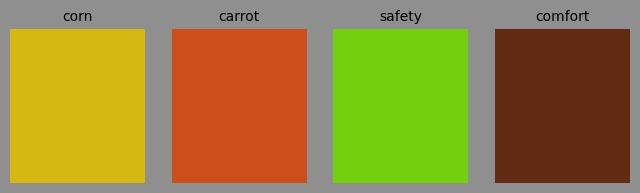


Optimal color assignment for concept set 8:
['#000000', '#d5b811', '#67cf5c', '#c94e4b']


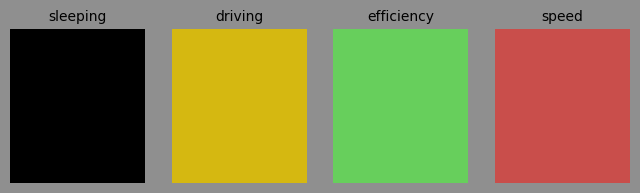


Optimal color assignment for concept set 9:
['#d5b811', '#cc4f1b', '#f1a78a', '#e81a4b']


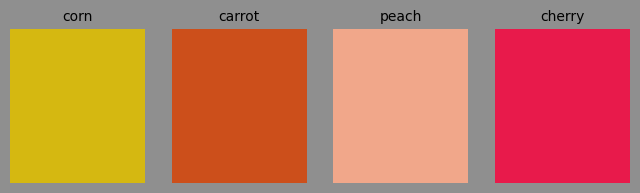


Optimal color assignment for concept set 10:
['#000000', '#ea1d1d', '#72005e', '#f7db7c']


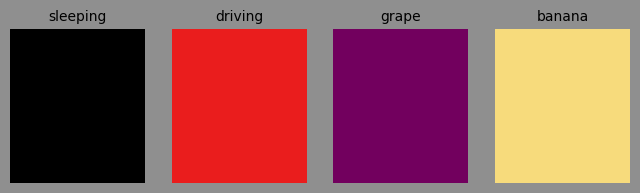


Optimal color assignment for concept set 11:
['#632b14', '#cd26c7', '#1c3d61', '#ea1d1d']


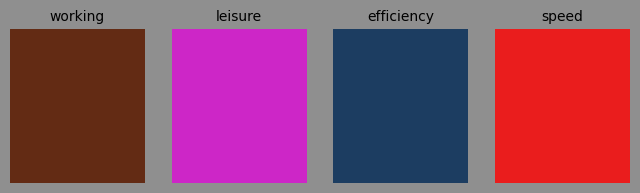


Optimal color assignment for concept set 12:
['#600b84', '#a3c55b', '#d5b811', '#632b14']


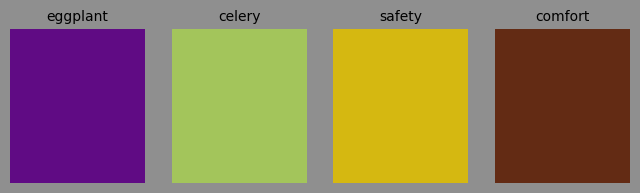


Optimal color assignment for concept set 13:
['#777777', '#4bcf8e', '#f1a78a', '#ea1d1d']


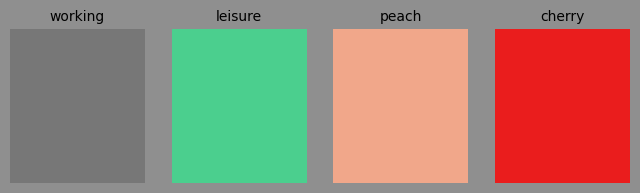


Optimal color assignment for concept set 14:
['#512d5f', '#96c58c', '#cd26c7', '#d5b811']


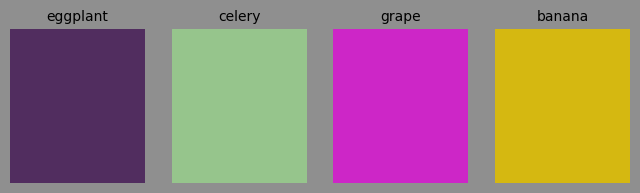


Optimal color assignment for concept set 15:
['#d5b811', '#ac6619', '#73f5b0', '#ea1d1d']


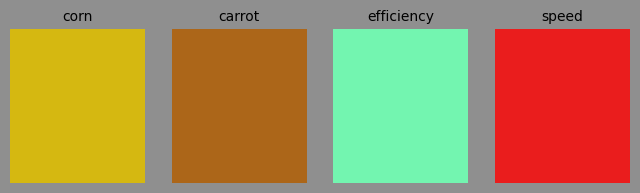


Optimal color assignment for concept set 16:
['#000000', '#ea1d1d', '#d0e942', '#632b14']


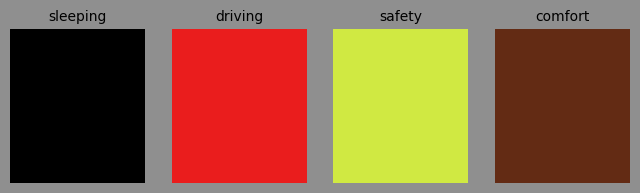

In [77]:
gpt_assignments = []
for i in range(len(plist)):
    concepts = plist[i]
    subset = gpt_assoc_hex_images[gpt_assoc_hex_images['concept'].isin(concepts)]
    
    subset['concept'] = pd.Categorical(subset['concept'], categories=concepts, ordered=True)
    subset = subset.sort_values('concept')

    ratings = subset.drop('concept', axis=1).values
    color_assignment = assignment_solve(ratings, method='balanced')
    selected_colors = color_dict.iloc[color_assignment]['color_hex'].tolist()
    
    print('Optimal color assignment for concept set {}:'.format(i+1))
    print(selected_colors)
    visualize_color_patches(selected_colors, concepts)
    print('')
    assignment_dict = {concept: color for concept, color in zip(concepts, selected_colors)}
    gpt_assignments.append(assignment_dict)


In [78]:
true_assignments

[{'corn': '#ffffff',
  'carrot': '#cc4f1b',
  'grape': '#600b84',
  'banana': '#c8e97d'},
 {'sleeping': '#512d5f',
  'driving': '#3efe44',
  'peach': '#f1a78a',
  'cherry': '#ea1d1d'},
 {'working': '#000000',
  'leisure': '#8558f4',
  'safety': '#dddddd',
  'comfort': '#a06776'},
 {'eggplant': '#600b84',
  'celery': '#0e8a19',
  'efficiency': '#5e78a1',
  'speed': '#ea1d1d'},
 {'working': '#3b3b3b',
  'leisure': '#a0bae6',
  'grape': '#600b84',
  'banana': '#fcdb42'},
 {'eggplant': '#600b84',
  'celery': '#73cf10',
  'peach': '#f7a75a',
  'cherry': '#ea1d1d'},
 {'corn': '#fcdb42',
  'carrot': '#cc4f1b',
  'safety': '#8cf47e',
  'comfort': '#a06776'},
 {'sleeping': '#512d5f',
  'driving': '#0e8a19',
  'efficiency': '#ffffff',
  'speed': '#e81a4b'},
 {'corn': '#d5b811',
  'carrot': '#ac6619',
  'peach': '#f1a78a',
  'cherry': '#ea1d1d'},
 {'sleeping': '#1c3d61',
  'driving': '#ea1d1d',
  'grape': '#b62ef2',
  'banana': '#d0b85a'},
 {'working': '#3b3b3b',
  'leisure': '#90689f',
  'effici

In [87]:


{f"{ind}":val for ind,val in enumerate(gpt_assignments)}

{'0': {'corn': '#c7b88b',
  'carrot': '#cc4f1b',
  'grape': '#600b84',
  'banana': '#d0e942'},
 '1': {'sleeping': '#000000',
  'driving': '#d5b811',
  'peach': '#f7a75a',
  'cherry': '#e81a4b'},
 '2': {'working': '#777777',
  'leisure': '#cd26c7',
  'safety': '#73cf10',
  'comfort': '#632b14'},
 '3': {'eggplant': '#72005e',
  'celery': '#608218',
  'efficiency': '#b9b9b9',
  'speed': '#ea1d1d'},
 '4': {'working': '#777777',
  'leisure': '#4bcf8e',
  'grape': '#512d5f',
  'banana': '#d5b811'},
 '5': {'eggplant': '#3518ad',
  'celery': '#aac510',
  'peach': '#f7a75a',
  'cherry': '#ea1d1d'},
 '6': {'corn': '#d5b811',
  'carrot': '#cc4f1b',
  'safety': '#73cf10',
  'comfort': '#632b14'},
 '7': {'sleeping': '#000000',
  'driving': '#d5b811',
  'efficiency': '#67cf5c',
  'speed': '#c94e4b'},
 '8': {'corn': '#d5b811',
  'carrot': '#cc4f1b',
  'peach': '#f1a78a',
  'cherry': '#e81a4b'},
 '9': {'sleeping': '#000000',
  'driving': '#ea1d1d',
  'grape': '#72005e',
  'banana': '#f7db7c'},
 '10': 

### Check data

In [1]:
### read in all the .csv files in data/assignment_inference_data
import os
import pandas as pd
import numpy as np

path = '../../data/assignment_inference_data'
files = os.listdir(path)
ai_df = pd.DataFrame()
for file in files:
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(path, file))
        df['file'] = file
        ai_df = pd.concat([ai_df, df])

In [2]:
ai_df.sona_id.nunique()

86

In [3]:
ai_trials = ai_df[ai_df['trial_type'] == 'assignment-inference']
ai_trials = ai_trials[~ai_trials['category'].isin(['"catch_trial"','"practice_trial"'])].reset_index(drop=True)

In [4]:
ai_trials.groupby('category')['total accuracy'].mean()

category
"0"     2.580000
"1"     3.157500
"10"    1.630814
"11"    3.546512
"12"    3.348837
"13"    3.468023
"14"    3.575581
"15"    3.404070
"2"     2.050000
"3"     3.022500
"4"     2.780000
"5"     3.460000
"6"     3.032500
"7"     2.375000
"8"     3.953488
"9"     3.863372
Name: total accuracy, dtype: float64

In [5]:
ai_trials

,rt,stimulus,button_pressed,trial_type,trial_index,time_elapsed,internal_node_id,subject_id,sona_id,success,...,answer_key,label_responses,condition,repetition,category,pal_source,accuracies,total accuracy,order_num,file
0,12340.0,NaN,NaN,assignment-inference,11,67393,0.0-11.0,pv8mjorbc3,88441,NaN,...,"[""working"",""leisure"",""peach"",""cherry""]","[""working"",""leisure"",""peach"",""cherry""]","""set1""",0.0,"""12""","""uw_71""","[1,1,1,1]",4.0,4.0,pv8mjorbc3.csv
1,18232.0,NaN,NaN,assignment-inference,12,85627,0.0-12.0,pv8mjorbc3,88441,NaN,...,"[""working"",""leisure"",""efficiency"",""speed""]","[""working"",""efficiency"",""leisure"",""speed""]","""set1""",0.0,"""10""","""uw_71""","[1,0,0,1]",2.0,4.0,pv8mjorbc3.csv
2,12265.0,NaN,NaN,assignment-inference,13,97893,0.0-13.0,pv8mjorbc3,88441,NaN,...,"[""corn"",""carrot"",""efficiency"",""speed""]","[""corn"",""carrot"",""speed"",""efficiency""]","""set1""",0.0,"""14""","""uw_71""","[1,1,0,0]",2.0,4.0,pv8mjorbc3.csv
3,13394.0,NaN,NaN,assignment-inference,14,111288,0.0-14.0,pv8mjorbc3,88441,NaN,...,"[""corn"",""carrot"",""peach"",""cherry""]","[""corn"",""carrot"",""peach"",""cherry""]","""set1""",0.0,"""8""","""uw_71""","[1,1,1,1]",4.0,4.0,pv8mjorbc3.csv
4,14018.0,NaN,NaN,assignment-inference,15,125308,0.0-15.0,pv8mjorbc3,88441,NaN,...,"[""eggplant"",""celery"",""safety"",""comfort""]","[""comfort"",""celery"",""eggplant"",""safety""]","""set1""",0.0,"""11""","""uw_71""","[0,1,0,0]",1.0,4.0,pv8mjorbc3.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5947,6573.0,NaN,NaN,assignment-inference,85,617306,0.0-85.0,hja5vlht4p,88481,NaN,...,"[""sleeping"",""driving"",""peach"",""cherry""]","[""sleeping"",""driving"",""peach"",""cherry""]","""set2""",7.0,"""1""","""uw_71""","[1,1,1,1]",4.0,0.0,hja5vlht4p.csv
5948,6751.0,NaN,NaN,assignment-inference,86,624058,0.0-86.0,hja5vlht4p,88481,NaN,...,"[""corn"",""carrot"",""grape"",""banana""]","[""banana"",""carrot"",""grape"",""corn""]","""set2""",7.0,"""0""","""uw_71""","[0,1,1,0]",2.0,0.0,hja5vlht4p.csv
5949,7012.0,NaN,NaN,assignment-inference,87,631071,0.0-87.0,hja5vlht4p,88481,NaN,...,"[""corn"",""carrot"",""safety"",""comfort""]","[""corn"",""carrot"",""safety"",""comfort""]","""set2""",7.0,"""6""","""uw_71""","[1,1,1,1]",4.0,0.0,hja5vlht4p.csv
5950,9665.0,NaN,NaN,assignment-inference,88,640737,0.0-88.0,hja5vlht4p,88481,NaN,...,"[""eggplant"",""celery"",""peach"",""cherry""]","[""eggplant"",""celery"",""peach"",""cherry""]","""set2""",7.0,"""5""","""uw_71""","[1,1,1,1]",4.0,0.0,hja5vlht4p.csv


In [6]:
subject_id=[]
rt=[]
trial_index=[]
#label_option=[]
bar_col=[]
answer=[]
response=[]
condition=[]
repetition=[]
category=[]
pal_source=[]
accuracy=[]
total_accuracy=[]
order_num=[]
x=0



for index,row in ai_trials.iterrows():
    
    for i in range(4):
        rt.append(row.rt)
        trial_index.append(index)
        #label_option.append( eval(row.label_options))
        bar_col.append(eval(row.bar_cols)[i])
        answer.append(eval(row.answer_key)[i])
        response.append( eval(row.label_responses)[i])
        condition.append(row.condition)
        repetition.append(row.repetition)
        category.append(row.category)
        pal_source.append( row.pal_source)
        accuracy.append( eval(row.accuracies)[i])
        total_accuracy.append(row['total accuracy'])
        order_num.append(row.order_num)
        subject_id.append(row.subject_id)
        


In [7]:
cat_con_dict = {'fruits':['cherry','peach','grape','banana'],'vegetables':['corn','carrot','celery','eggplant'],
               'activities':['working','sleeping','driving','leisure'],'features':['efficiency','speed','safety','comfort']}


con_cat_dict = {i: k for k, v in cat_con_dict.items() for i in v}

In [8]:
clean_df = pd.DataFrame({'subject_id':subject_id,'trial_index':trial_index,'condition':condition,'pal_source':pal_source,'order_num':order_num,\
               'category':category,'repetition':repetition,'answer':answer,\
               'bar_col':bar_col,'response':response,\
             'accuracy':accuracy,'total_accuracy':total_accuracy,'rt':rt})

In [9]:
clean_df.category.unique()

array(['"12"', '"10"', '"14"', '"8"', '"11"', '"13"', '"9"', '"15"',
       '"6"', '"4"', '"5"', '"3"', '"1"', '"0"', '"7"', '"2"'],
      dtype=object)

In [10]:
clean_df['concreteness_cond'] = clean_df.apply(lambda x: 'conc' if x.category in ['"8"','"13"'] \
                                                   else ('abs' if x.category in ['"10"','"15"']\
                                                              else'mix'), axis=1 )

clean_df['context']= clean_df.apply(lambda x: 'within' if x.concreteness_cond in ['conc','abs'] else 'across', axis = 1)

clean_df['concept_cat'] = clean_df.apply(lambda x:con_cat_dict[x.answer], axis = 1)

clean_df['con_pal_conc'] = clean_df['condition'] +clean_df['category'].str.split('"').str[1] + clean_df['answer']

In [11]:

plot_df = clean_df.groupby(['bar_col','con_pal_conc','subject_id','category','condition','response' ]).\
apply(lambda x: len(x)/8).reset_index(name= 'num_times_picked')
col_dict= {a:a for a in plot_df.bar_col.unique()}

pair_labels = []
for index, row in clean_df.iterrows():
    if row.answer in ['grape','banana']:
        pair_labels.append('fruit1')
    elif row.answer in ['peach','cherry']:
        pair_labels.append('fruit2')
    elif row.answer in ['carrot','corn']:
        pair_labels.append('veg1')  
    elif row.answer in ['celery','eggplant']:
        pair_labels.append('veg2')
    elif row.answer in ['safety','comfort']:
        pair_labels.append('feat2')
    elif row.answer in ['speed','efficiency']:
        pair_labels.append('feat1')
    elif row.answer in ['working','leisure']:
        pair_labels.append('act2')
    elif row.answer in ['driving','sleeping']:
        pair_labels.append('act1')

clean_df['pair_labels'] = pair_labels

/var/folders/62/ybvc3cw53hj40799y980__gr0000gn/T/ipykernel_23904/3455600128.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  apply(lambda x: len(x)/8).reset_index(name= 'num_times_picked')


In [12]:
cond_acc = clean_df.groupby(['condition','concreteness_cond'])[['total_accuracy','rt']].agg(['mean','sem']).reset_index()
cond_acc.columns = ['_'.join(col).strip('_') for col in cond_acc.columns.values]


In [13]:
plot_df = clean_df.groupby(['bar_col','con_pal_conc','subject_id','category','condition','response' ]).\
apply(lambda x: len(x)/8).reset_index(name= 'num_times_picked')
col_dict= {a:a for a in plot_df.bar_col.unique()}

/var/folders/62/ybvc3cw53hj40799y980__gr0000gn/T/ipykernel_23904/2246468287.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  apply(lambda x: len(x)/8).reset_index(name= 'num_times_picked')


In [14]:
plot_df_backup = plot_df.copy()
rows_to_add = []

for pal in plot_df_backup.category.unique():
    dp = plot_df_backup[plot_df_backup.category == pal]
    for cond in dp.condition.unique():
        dpp = dp[dp.condition == cond]
        concepts = dpp.response.unique()
        for col in dpp.bar_col.unique():
            dppp = dpp[dpp.bar_col == col]
            for subj in dppp.subject_id.unique():
                dp_ = dppp[dppp.subject_id == subj]
                for conc in concepts:
                    if conc not in dp_.response.unique():
                        rows_to_add.append([col, 'NA', subj, pal, cond, conc, 0])

# Create a DataFrame from the collected rows and concatenate it with the original DataFrame
if rows_to_add:
    new_rows_df = pd.DataFrame(rows_to_add, columns=plot_df.columns)
    plot_df = pd.concat([plot_df, new_rows_df], ignore_index=True)

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
p1 = ['corn','carrot','grape','banana']
p2 =['sleeping','driving','peach','cherry']
p3 = ['working','leisure','safety','comfort']
p4 = ['eggplant','celery','efficiency','speed']
p5= ['working','leisure','grape','banana']
p6 = ['eggplant','celery','peach','cherry']
p7 = ['corn','carrot','safety','comfort']
p8 = ['sleeping','driving','efficiency','speed']
p9 = ['corn','carrot','peach','cherry']
p10 = ['sleeping','driving','grape','banana']
p11 = ['working','leisure','efficiency','speed']
p12 = ['eggplant','celery','safety','comfort']
p13 = ['working','leisure','peach','cherry']
p14 = ['eggplant','celery','grape','banana']
p15 = ['corn','carrot','efficiency','speed',]
p16 = ['sleeping','driving','safety','comfort']
plist=[
    p1,p2,p3,p4,p5,p6,p7,p8,
       p9,p10,p11,p12,p13,p14,p15,p16]

true_assignments =  [{
        "corn": "#c7b88b",
        "carrot": "#cc4f1b",
        "grape": "#600b84",
        "banana": "#d0e942"
    },{
        "sleeping": "#000000",
        "driving": "#d5b811",
        "peach": "#f7a75a",
        "cherry": "#e81a4b"
    },{
        "working": "#777777",
        "leisure": "#cd26c7",
        "safety": "#73cf10",
        "comfort": "#632b14"
    },{
        "eggplant": "#72005e",
        "celery": "#608218",
        "efficiency": "#b9b9b9",
        "speed": "#ea1d1d"
    }, {
        "working": "#777777",
        "leisure": "#4bcf8e",
        "grape": "#512d5f",
        "banana": "#d5b811"
    }, {
        "eggplant": "#3518ad",
        "celery": "#aac510",
        "peach": "#f7a75a",
        "cherry": "#ea1d1d"
    },{
        "corn": "#d5b811",
        "carrot": "#cc4f1b",
        "safety": "#73cf10",
        "comfort": "#632b14"
    }, {
        "sleeping": "#000000",
        "driving": "#d5b811",
        "efficiency": "#67cf5c",
        "speed": "#c94e4b"
    },    
     {
        "corn": "#d5b811",
        "carrot": "#cc4f1b",
        "peach": "#f1a78a",
        "cherry": "#e81a4b"
    }, {
        "sleeping": "#000000",
        "driving": "#ea1d1d",
        "grape": "#72005e",
        "banana": "#f7db7c"
    },{
        "working": "#632b14",
        "leisure": "#cd26c7",
        "efficiency": "#1c3d61",
        "speed": "#ea1d1d"
    }, {
        "eggplant": "#600b84",
        "celery": "#a3c55b",
        "safety": "#d5b811",
        "comfort": "#632b14"
    }, {
        "working": "#777777",
        "leisure": "#4bcf8e",
        "peach": "#f1a78a",
        "cherry": "#ea1d1d"
    }, {
        "eggplant": "#512d5f",
        "celery": "#96c58c",
        "grape": "#cd26c7",
        "banana": "#d5b811"
    }, {
        "corn": "#d5b811",
        "carrot": "#ac6619",
        "efficiency": "#73f5b0",
        "speed": "#ea1d1d"
    }, {
        "sleeping": "#000000",
        "driving": "#ea1d1d",
        "safety": "#d0e942",
        "comfort": "#632b14"
    }
]


In [19]:
plot_df

,bar_col,con_pal_conc,subject_id,category,condition,response,num_times_picked
0,#000000,"""set1""15sleeping",0tw0ow8ems,"""15""","""set1""",sleeping,1.000
1,#000000,"""set1""15sleeping",1vvjhct8y6,"""15""","""set1""",driving,0.125
2,#000000,"""set1""15sleeping",1vvjhct8y6,"""15""","""set1""",safety,0.125
3,#000000,"""set1""15sleeping",1vvjhct8y6,"""15""","""set1""",sleeping,0.750
4,#000000,"""set1""15sleeping",1xxsddld4c,"""15""","""set1""",sleeping,1.000
...,...,...,...,...,...,...,...
15099,#f1a78a,NA,ysk7o5m4yd,"""8""","""set1""",cherry,0.000
15100,#f1a78a,NA,ysk7o5m4yd,"""8""","""set1""",corn,0.000
15101,#f1a78a,NA,yt8o923pd4,"""8""","""set1""",carrot,0.000
15102,#f1a78a,NA,yt8o923pd4,"""8""","""set1""",cherry,0.000


In [20]:
true_assignments

[{'corn': '#c7b88b',
  'carrot': '#cc4f1b',
  'grape': '#600b84',
  'banana': '#d0e942'},
 {'sleeping': '#000000',
  'driving': '#d5b811',
  'peach': '#f7a75a',
  'cherry': '#e81a4b'},
 {'working': '#777777',
  'leisure': '#cd26c7',
  'safety': '#73cf10',
  'comfort': '#632b14'},
 {'eggplant': '#72005e',
  'celery': '#608218',
  'efficiency': '#b9b9b9',
  'speed': '#ea1d1d'},
 {'working': '#777777',
  'leisure': '#4bcf8e',
  'grape': '#512d5f',
  'banana': '#d5b811'},
 {'eggplant': '#3518ad',
  'celery': '#aac510',
  'peach': '#f7a75a',
  'cherry': '#ea1d1d'},
 {'corn': '#d5b811',
  'carrot': '#cc4f1b',
  'safety': '#73cf10',
  'comfort': '#632b14'},
 {'sleeping': '#000000',
  'driving': '#d5b811',
  'efficiency': '#67cf5c',
  'speed': '#c94e4b'},
 {'corn': '#d5b811',
  'carrot': '#cc4f1b',
  'peach': '#f1a78a',
  'cherry': '#e81a4b'},
 {'sleeping': '#000000',
  'driving': '#ea1d1d',
  'grape': '#72005e',
  'banana': '#f7db7c'},
 {'working': '#632b14',
  'leisure': '#cd26c7',
  'effici

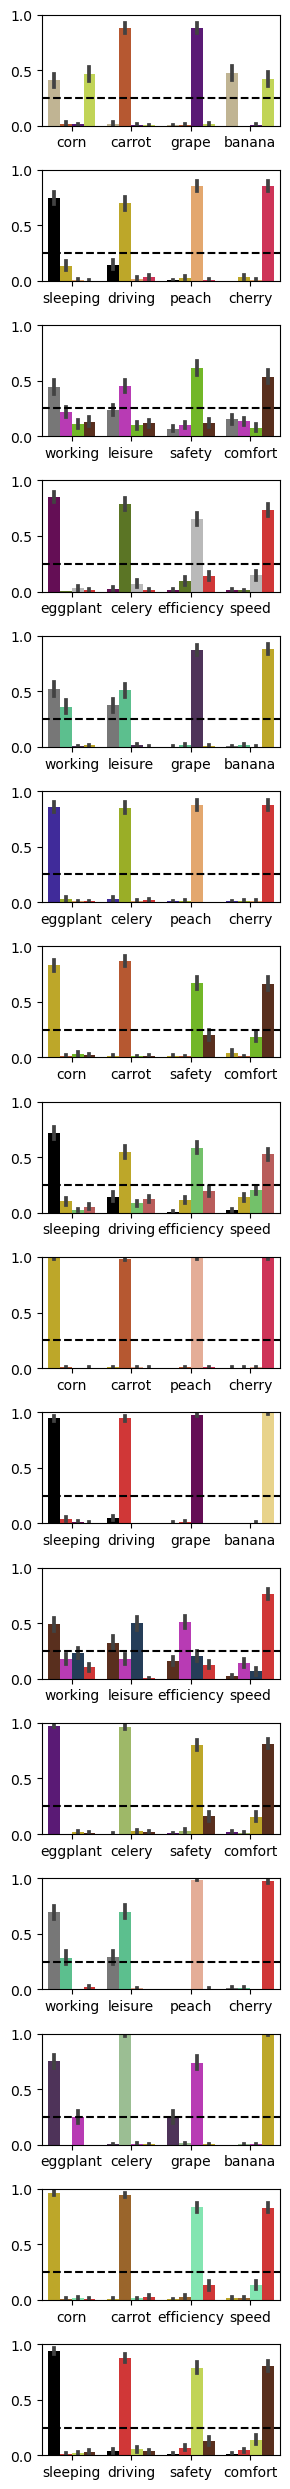

In [21]:
fig = plt.figure(figsize=(3,25))
plt.rcParams['pdf.fonttype'] = 42
sp=1

for j in range(16):
    

    pdf = plot_df[(plot_df.category ==f'"{j}"')]
    
    hue_ord=[]
    this_p = plist[j]
    for p in this_p:
        hue_ord.append(true_assignments[j][p])
    

    #sns.set_theme(style="white",rc = {'patch.linewidth': 0.5, 'patch.edgecolor':'black',})

    g = sns.barplot(ax = fig.add_subplot(16,1,sp),
        data=pdf,color = 'black',
        x="response", y="num_times_picked", hue="bar_col", palette =col_dict,
        errorbar='se', order = plist[j], hue_order= hue_ord
    )
    plt.axhline( y=0.25, ls='--', c='black')
    plt.xlabel('')
    ax = plt.gca()
    ax.get_legend().remove()
    plt.ylabel('')
    plt.ylim(0,1)
    plt.yticks([0,0.5,1])
    plt.tick_params(labelsize=10)
    #plt.show()

    
    sp+=1
plt.tight_layout()

#plt.savefig(f'../human_data_faceted.pdf',format='pdf')
    
